                                              Review     Label Sentiment  \
0  The problem with TV today is that people have ...  Positive  negative   
1  I first saw this film about 15 years ago, and ...  Positive     mixed   
2  I think every critic who panned "Tommy Boy" wh...  Positive     mixed   
3  One of our all time family favorites. When we ...  Positive  positive   
4  I absolutely loved every minute of this film. ...  Positive     mixed   

   Positive Confidence  Neutral Confidence  Negative Confidence  
0                 0.00                0.19                 0.81  
1                 0.72                0.13                 0.15  
2                 0.53                0.07                 0.39  
3                 0.92                0.07                 0.01  
4                 0.79                0.02                 0.19  


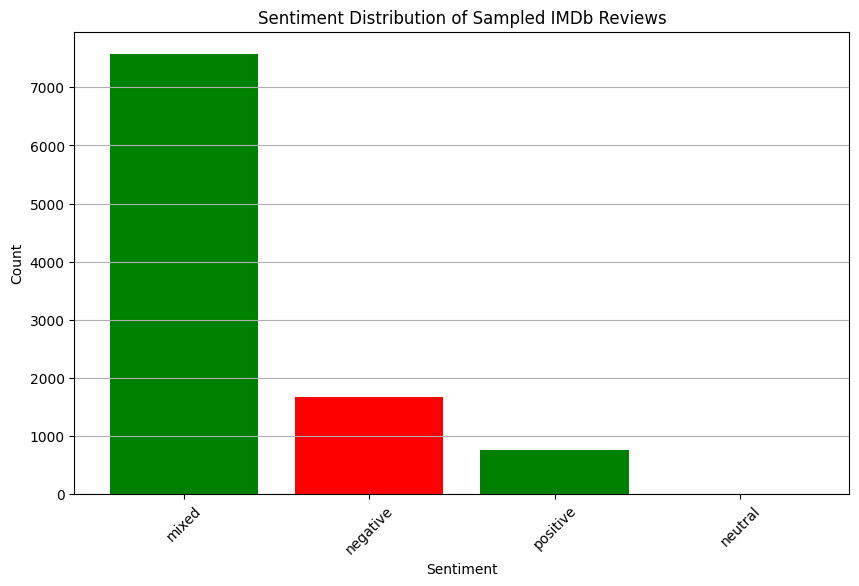

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


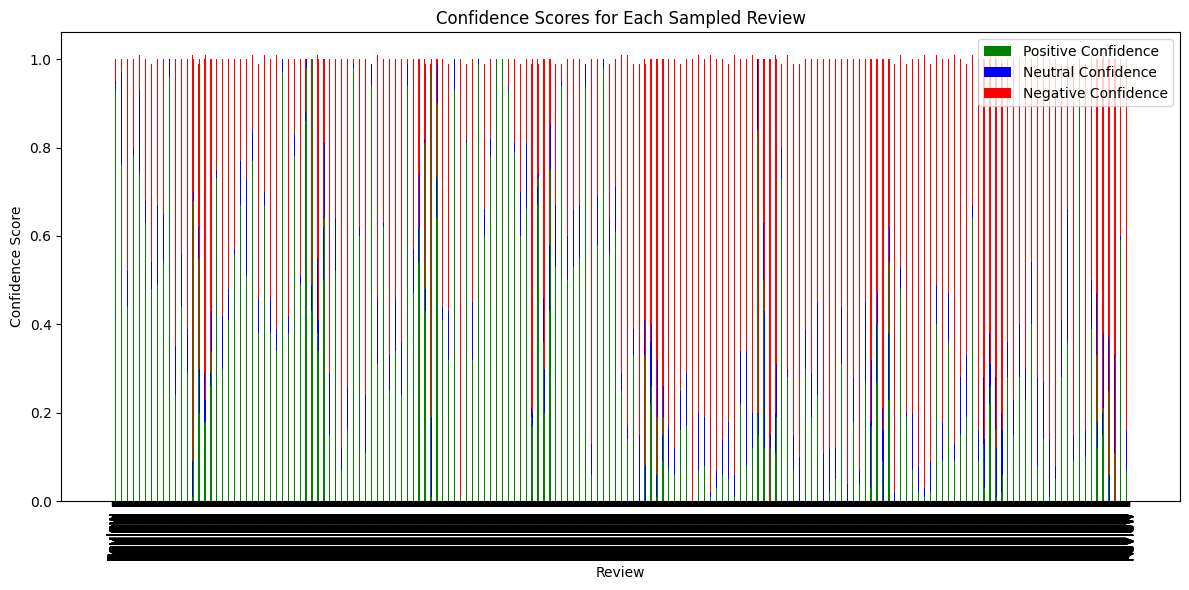

Scikit-learn Logistic Regression Accuracy: 0.87


In [8]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import os
from dotenv import load_dotenv
from azure.ai.textanalytics import TextAnalyticsClient
from azure.core.credentials import AzureKeyCredential
import random

plt.rcParams['font.family'] = 'DejaVu Sans'

load_dotenv()

api_key = os.getenv('AZURE_API_KEY')
endpoint = os.getenv('AZURE_ENDPOINT')

text_analytics_client = TextAnalyticsClient(endpoint=endpoint, credential=AzureKeyCredential(api_key))

pos_reviews_path = 'aclImdb/test/pos/'
neg_reviews_path = 'aclImdb/test/neg/'

def load_reviews_from_folder(folder, sample_size=None):
    reviews = []
    for filename in os.listdir(folder):
        with open(os.path.join(folder, filename), 'r', encoding='utf-8') as file:
            reviews.append(file.read())
    if sample_size:
        reviews = random.sample(reviews, min(sample_size, len(reviews)))
    return reviews

sample_size = 5000
MAX_DOCUMENT_LENGTH = 5120

def truncate_reviews(reviews):
    return [review[:MAX_DOCUMENT_LENGTH] for review in reviews]

positive_reviews = truncate_reviews(load_reviews_from_folder(pos_reviews_path, sample_size))
negative_reviews = truncate_reviews(load_reviews_from_folder(neg_reviews_path, sample_size))

documents = positive_reviews + negative_reviews
labels = ['Positive'] * len(positive_reviews) + ['Negative'] * len(negative_reviews)
df = pd.DataFrame({'Review': documents, 'Label': labels})

def analyze_sentiment_in_batches(reviews, batch_size=100):
    sentiments = []
    for i in range(0, len(reviews), batch_size):
        batch = reviews[i:i + batch_size]
        response = text_analytics_client.analyze_sentiment(documents=batch)
        sentiments.extend(response)
    return sentiments

sentiment_results = analyze_sentiment_in_batches(df['Review'].tolist(), batch_size=5)

df['Sentiment'] = [doc.sentiment for doc in sentiment_results]
df['Positive Confidence'] = [doc.confidence_scores.positive for doc in sentiment_results]
df['Neutral Confidence'] = [doc.confidence_scores.neutral for doc in sentiment_results]
df['Negative Confidence'] = [doc.confidence_scores.negative for doc in sentiment_results]

print(df.head())

sentiment_counts = df['Sentiment'].value_counts()

plt.figure(figsize=(10, 6))
plt.bar(sentiment_counts.index, sentiment_counts.values, color=['green', 'red'])
plt.title('Sentiment Distribution of Sampled IMDb Reviews')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

plt.figure(figsize=(12, 6))
bar_width = 0.2
index = range(len(df))

plt.bar(index, df['Positive Confidence'], bar_width, label='Positive Confidence', color='green')
plt.bar(index, df['Neutral Confidence'], bar_width, label='Neutral Confidence', color='blue', bottom=df['Positive Confidence'])
plt.bar(index, df['Negative Confidence'], bar_width, label='Negative Confidence', color='red', bottom=df['Positive Confidence'] + df['Neutral Confidence'])

plt.title('Confidence Scores for Each Sampled Review')
plt.xlabel('Review')
plt.ylabel('Confidence Score')
plt.xticks(index, ['Review'] * len(df), rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df['Review']).toarray()

y = df['Label'].apply(lambda x: 1 if x == 'Positive' else 0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

classifier = LogisticRegression(max_iter=1000)
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Scikit-learn Logistic Regression Accuracy: {accuracy:.2f}")
